# PA4 - LSTM for Music Generation (Version 1)

We will train an LSTM to generate music using the ABC Notation.

This approach is not implemented the right way. The music generated is garbage! 

X: >h fige  
W:.antie, :- Z:Fn?an0tan !atove? :Traneenretc  
O:T:b9 :Larg? ma:qra>jo:  
cT0and/g  
O:Fa | d2A  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import csv
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.5.4


## Functions

In [2]:
import torch

def num_datapoints(filename):
    """
    Given the name of a CVS file, the function returns the number of rows of data.
    Inputs:
    - filename: name of CVS file
    Returns:
    The number of rows of data
    """
    
    row_count = 0
    
    f = open(filename, 'rt')
    for line in f:
        row_count += 1
        
    f.close()

    return row_count

def num_chars(filename):
    """
    Given the name of a CVS file, the function returns the number of characters in the file.
    Inputs:
    - filename: name of CVS file
    Returns:
    The number of rows of data
    """
    
    char_count = 0
    
    f = open(filename, 'rt')
    for line in f:
        for c in line:
            char_count += 1
        
    f.close()

    return char_count


def extract_characters(filename):
    """
    Given the name of a file, the function returns a list of unique characters in the file.
    Inputs:
    - filename: name of CVS file
    Returns:
    A list of unique character
    """
    characters = []
    f = open(filename, 'rt')

    for line in f:
        for c in line:
            if c not in characters:
                characters.append(c)
    f.close()        
    return characters


def letterToIndex(letter, char_dict):
    """
    Find letter index from all_letters, e.g. "\t" = 0
    Inputs:
    - letter
    - char_dict: A dictionary of all possible characters
    Returns:
    Index of the letter in the dictionary
    """
    return char_dict.index(letter)

def letterToTensor(letter, char_dict):
    """
    Turn a letter into a <1 x len(char_dict)> Tensor representing its one-hot encoding.
    Inputs:
    - letter
    - char_dict: A dictionary of all possible characters
    Returns:
    tensor: One-hot encoding of the letter
    """
    tensor = torch.zeros(1, len(char_dict))
    tensor[0, letterToIndex(letter, char_dict)] = 1
    return tensor.view(1,-1)


def tensorToLetter(tensor, char_dict):
    """
    Turn a one-hot <1 x len(char_dict)> Tensor back to the letter
    Inputs:
    - letter
    - char_dict: A dictionary of all possible characters
    Returns:
    letter: One-hot encoding of the letter
    """
    index = torch.max(tensor.view(1,-1),1)[1]   # force tensor to 1xN dimension
    return char_dict[index.numpy()[0]]


def lineToTensor(line, char_dict):
    """
    Turn a line into an array of one-hot tensors <line_length x 1 x len(char_dict)>
    Inputs:
    - line
    - char_dict: A dictionary of all possible characters
    Returns:
    tensor: an array of one-hot tensors
    """
    tensor = torch.zeros(len(line), len(char_dict))
    for li, letter in enumerate(line):
        tensor[li, letterToIndex(letter, char_dict)] = 1
    return tensor

def display_batch(minibatch, char_dict):
    line = ''
    for tensor in minibatch:
        char = tensorToLetter(tensor, char_dict)
        line = line + char
    return line

def generateCorpus(filename, dictionary):
    """
    Take all the content in a text file and generate a corpus of one-hot encodings.
    Inputs:
    - filename
    - dictionary: A dictionary of all possible characters
    Returns:
    corpus: a tensor of <total_chars, 1, len(dictionary)>
    """
    
    total_chars = num_chars(filename)  # figure out how many char in the file
    corpus = torch.zeros(total_chars, len(dictionary))
    i = 0

    f = open(filename, 'rt')
    for line in f:
        for c in line:
            corpus[i, letterToIndex(c, dictionary)] = 1  # one-hot encoding
            i += 1
            
    f.close()  
    return corpus

def prepare_sequence(batch):
    seq = []
    for i in range(batch.size([0])):
        seq.append(batch[i,:])
        tensor = torch.LongTensor(seq)
    return Variable(tensor)


## Generate Dictionary

We parse through input.txt and extract all unique characters.

In [3]:
filename = 'input.txt'

inputfile = open(filename, 'rt')

# explore the content of the input.txt file
i = 0
for line in inputfile:
    if i < 10:
        print (line)
        i += 1
    
inputfile.close()

print (type(line))  # line are read in as strings

print (num_datapoints(filename))  # 18711 rows in the file
print (num_chars(filename))  # 501470 characters in the file

char_dict = sorted(extract_characters(filename))   # 93 unique characters

print (char_dict)
print (len(char_dict))

<start>

X:1

T: La Montfarine

Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-24

Z:Pour toute observation mailto:galouvielle@free.fr

M: 4/4

L: 1/8

Q:1/4=186

FGF B=AG G=AG F2F FGF {F}F2E EFE|

{E}E2D FGF B=AG G=AG {F}F2F FED C2G D2E|F3 {F}F/2 ED E3/2D/2|

<class 'str'>
18711
501470
['\t', '\n', ' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']
93


## Generate Corpus

In [4]:
filename = 'input.txt'
corpus = generateCorpus(filename, char_dict)

print (corpus.size())
print(display_batch(corpus[0:100,:], char_dict))

torch.Size([501470, 93])
<start>
X:1
T: La Montfarine
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-24
Z:Pour toute o


## Train and Validation Split

We will split characters from the input.txt 80-20 into test and val datasets.

In [5]:
import torchvision.transforms as transforms

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 401470
NUM_VAL = 100000

loader_train = DataLoader(corpus, batch_size=32, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_val = DataLoader(corpus, batch_size=32, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


## Build LSTM

Pytorch’s LSTM expects all of its inputs to be 3D tensors:  

* The first axis is the sequence itself  
* the second indexes instances in the mini-batch, and  
* the third indexes elements of the input.  

Below, we build an LSTM, and run a sequence of 5 inputs through it generating 5 outputs. 

In [6]:
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor  # the GPU datatype

class LSTM_ABC(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM_ABC, self).__init__()
        self.hidden_dim = hidden_dim

        # We encode the character as 1-hot, so skip this step
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes 1-hot as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to output (1-hot)
        self.hidden2out = nn.Linear(hidden_dim, output_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # We initialize hx and cx
        if torch.cuda.is_available():
            hx = Variable(torch.zeros(1, 1, self.hidden_dim).cuda())
            cx = Variable(torch.zeros(1, 1, self.hidden_dim).cuda())
        else:
            hx = Variable(torch.zeros(1, 1, self.hidden_dim))
            cx = Variable(torch.zeros(1, 1, self.hidden_dim))            
        return (hx,cx)

    def forward(self, sentence):
        # embeds = self.word_embeddings(sentence)  # input is already 1-hot
        out, self.hidden = self.lstm(sentence.view(len(sentence), 1, -1), self.hidden)
        out = self.hidden2out(out.view(len(sentence), -1))
        scores = F.log_softmax(out)  # output log_softmax
        return scores

## Dimension Check

In [7]:
RNN = LSTM_ABC(93, 100, 93).type(gpu_dtype)

x = torch.randn(32, 93)
x_var = Variable(x.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data

print (x_var)
log_prob = RNN(x_var)        # Feed it through the model! 

print (log_prob.size())

Variable containing:
 6.6070e-01  1.3356e+00  1.1638e+00  ...   5.8624e-01  8.0986e-01  8.7389e-01
-3.3408e-01 -1.2273e-01  1.2107e-01  ...   4.9709e-01 -1.1391e+00 -6.5605e-01
-1.6161e+00  2.6525e+00 -8.7807e-01  ...  -1.4024e+00 -5.9409e-01 -6.7979e-01
                ...                   ⋱                   ...                
 1.4023e+00  5.2695e-01  4.0012e-01  ...   9.5999e-01 -7.5821e-01  7.5429e-01
-1.9691e+00  3.4790e-01  8.4739e-01  ...  -1.9768e+00 -3.9197e-01 -5.3130e-01
-1.0685e+00 -1.0034e+00  3.8652e-01  ...   1.3969e+00  1.2622e-01  2.9221e-01
[torch.cuda.FloatTensor of size 32x93 (GPU 0)]

torch.Size([32, 93])


In [ ]:
def evaluate(prime_str='X', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    
    prime_input = letterToTensor(prime_str, char_dict)
    predicted = prime_str
    
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _ = model(prime_input[p])
     
    inp = prime_input   # The prime character is input to LSTM
    
    for p in range(predict_len):
        output = model(Variable(inp.type(gpu_dtype)))
                
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = char_dict[top_i]
        predicted += predicted_char
        
        inp = letterToTensor(predicted_char, char_dict)

    return predicted

In [ ]:
n_epochs = 2000
print_every = 1
plot_every = 10
input_dim = 93
output_dim = 93
hidden_dim = 100
# n_layers = 1
lr = 0.001
verbose = False

# Create an instance of the LSTM and set optimizer and loss function
model = LSTM_ABC(input_dim, hidden_dim, output_dim).type(gpu_dtype)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# The output of the model is softmax log prob, so the loss function is 
# NLL (negative log likelihood)
loss_function = nn.NLLLoss()   

all_losses = []  # keep track of loss history

for epoch in range(1, n_epochs + 1):
    # loss = train(*random_training_set())   
    
    loss = 0

    for t, sentence in enumerate(loader_train):
        
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        hidden = model.init_hidden()
       
        # Step 2. Get our inputs and targets ready for the network
        # input will be fed character by character into LSTM
        inp = sentence[:-1,:]
        if verbose:
            print(display_batch(inp, char_dict)) 
        # LSTM output will be compared against the target, which is 
        target = sentence[1:,:].type(torch.LongTensor)  
        if verbose:
            print(display_batch(target, char_dict))
        
        # Step 3. Run our forward pass.
        target = target.cuda()
        scores = model(Variable(inp.type(gpu_dtype)))
        if verbose:
            print (scores.size())
            print (target.size())
            
       # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        target_index = torch.max(target,1)[1]  # NLLoss accept index as target, not one-hot
        loss = loss_function(scores, Variable(target_index))
        loss.backward(retain_graph=True)
        # torch.nn.utils.clip_grad_norm(model.parameters(), 50)
        optimizer.step()
        
        if t%100 == 0:
            print ("batch #:{}   loss: {} ".format(t, loss.data[0]/len(sentence)))
            predicted = evaluate(prime_str='X')
            print("Primed with X:")
            print(predicted)
            predicted = evaluate(prime_str='<')
            print("Primed with <:")
            print(predicted) 
            all_losses.append(loss.data[0]/len(sentence))
    
 
    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / n_epochs * 100, loss))



batch #:0   loss: 0.14146967232227325 
Primed with X:
X~YyTqo1 xS:5+]1^ysgX4cxsZt1Fem8>.,|^Nn#t'3Q1D !'w
<p [M"_-*W D(mZRqDiF'cfHC(Hr8#JT6R'{h3)?mEF~WQ.J_X
Primed with <:
<IA2xl-M4,k4faK-C\An'QWH+pWe@3neW!>!bn7e8/GOk_Jkc}nH|7dMt#(l)(lV:TN!aQ>,)&G438a<g /xj+.Qd5)5q"u6vs
Aw
batch #:100   loss: 0.11139734834432602 
Primed with X:
X2 >Buddd tc24ee!4dB |  d|d| B|2 |2
3 i  -c:a|c : e cBP B2e_e> frfe |c42
2 2|d dB|   t|2d F  |e 
 faB
Primed with <:
<2a
2p24 2c1 ||BAr22 | F|22| dz2B2  2BeGFo _21|Bu2  r|2Gb2|F2gg , e4fA2 2cE:][
-e2B|e 2 224B| cd ||f2
batch #:200   loss: 0.10474832355976105 
Primed with X:
Xc/ .e/./B/!///d/c//B/c_c//c/c/6 B= nc! =cG //2)/ ./ g +/gg/eac|B// /B g//  B=2/ //d/! B!///Bef/>+Bd/
Primed with <:
<B Bd /cBcA/ d  B.//c cc!= /BBcB // d / cd/! /ce|d/ 2//e.c  B  d/f//df//B//dc/=Bcd.d//d/|dB=dB./|.e d
batch #:300   loss: 0.11632761359214783 
Primed with X:
X  e! ue|e  2G| |  BBd: |/ |e bed  2!|dc|cr|/de|  : rd(o2  {  d )|V eg|c.dec3)ec+B T  !2B | ef
t ! ||
Primed with <:
<( f

In [64]:
predicted = evaluate()

print(predicted)

X:116
L:1/8
O:1
R:3e"stoderit on coutielsove?.er tonceltames pari? sarnscitem(itomte paisle 12e cELLO


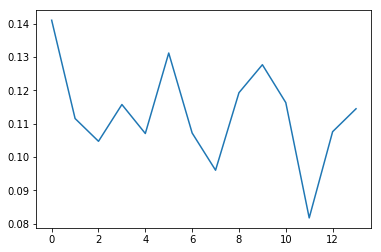

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)